In [1]:
import numpy as np
import matplotlib
matplotlib.use("nbagg")
import matplotlib.pyplot as plt

from matplotlib import gridspec 
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
nx   = 500        
nz   = nx         

dx   = 1.         
dz   = dx         
c0   = 580.       
isx  = 250        
isz  = isx        
irx  = 330        
irz  = isz        
nt   = 400        
dt   = 0.0010     
f0   = 150. 
t0   = 4. / f0 
op   = 3          

print('Source frequency =', f0, 'Hz')

eps  = c0 * dt / dx
print('Stability criterion =', eps)

p    = np.zeros((nz, nx)) 
pold = np.zeros((nz, nx)) 
pnew = np.zeros((nz, nx)) 
d2px = np.zeros((nz, nx)) 
d2pz = np.zeros((nz, nx)) 

c    = np.zeros((nz, nx))
c    = c + c0            

x    = np.arange(nx)
x    = x * dx           
z    = np.arange(nz)
z    = z * dz           

seis = np.zeros(nt)

Source frequency = 150.0 Hz
Stability criterion = 0.58


In [3]:
src  = np.zeros(nt + 1)
time = np.linspace(0 * dt, nt * dt, nt)
src  = -2. * (time - t0) * (f0 ** 2) * (np.exp(-1.0 * (f0 ** 2) * (time - t0) ** 2))

<IPython.core.display.Javascript object>


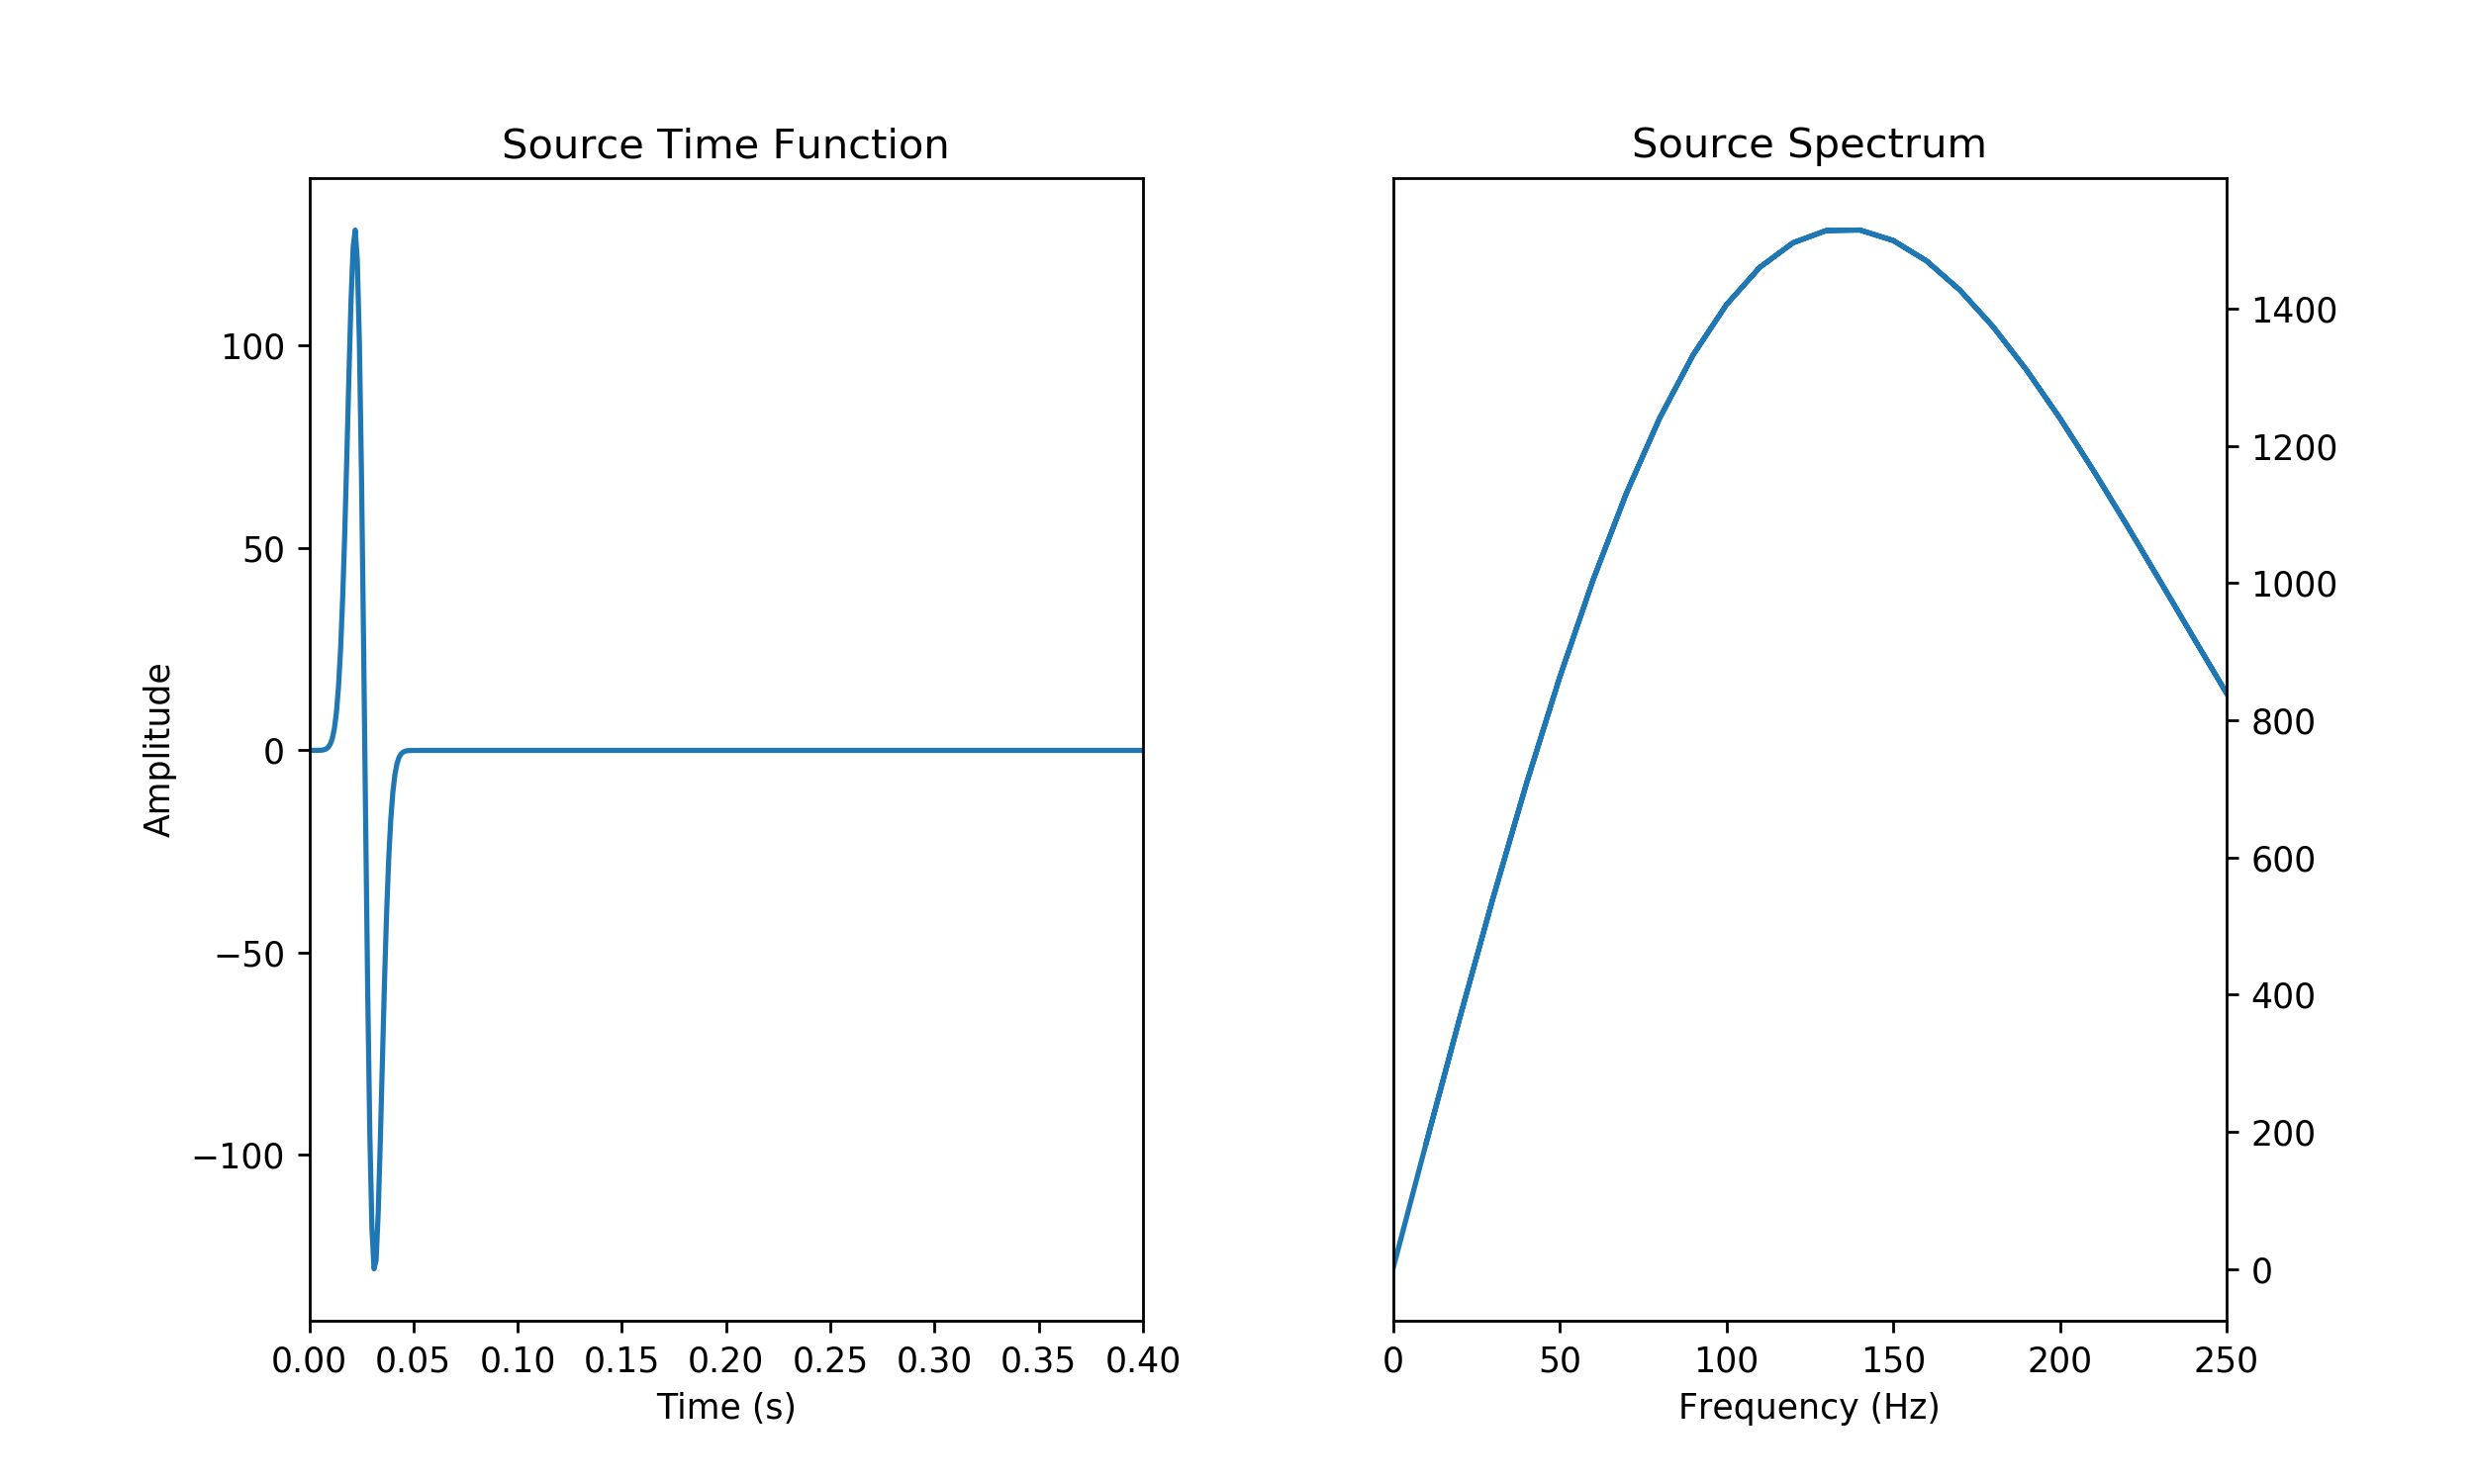

In [4]:
plt.ion()
fig1 = plt.figure(figsize=(10, 6))
gs1  = gridspec.GridSpec(1, 2, width_ratios=[1, 1], hspace=0.3, wspace=0.3)

ax1  = plt.subplot(gs1[0])
ax1.plot(time, src) 
ax1.set_title('Source Time Function')
ax1.set_xlim(time[0], time[-1])
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Amplitude')

ax2  = plt.subplot(gs1[1])
spec = np.fft.fft(src)
freq = np.fft.fftfreq(spec.size, d = dt / 4.)
ax2.plot(np.abs(freq), np.abs(spec))
ax2.set_xlim(0, 250) 
ax2.set_title('Source Spectrum')
ax2.set_xlabel('Frequency (Hz)')

ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")

plt.show()

<IPython.core.display.Javascript object>


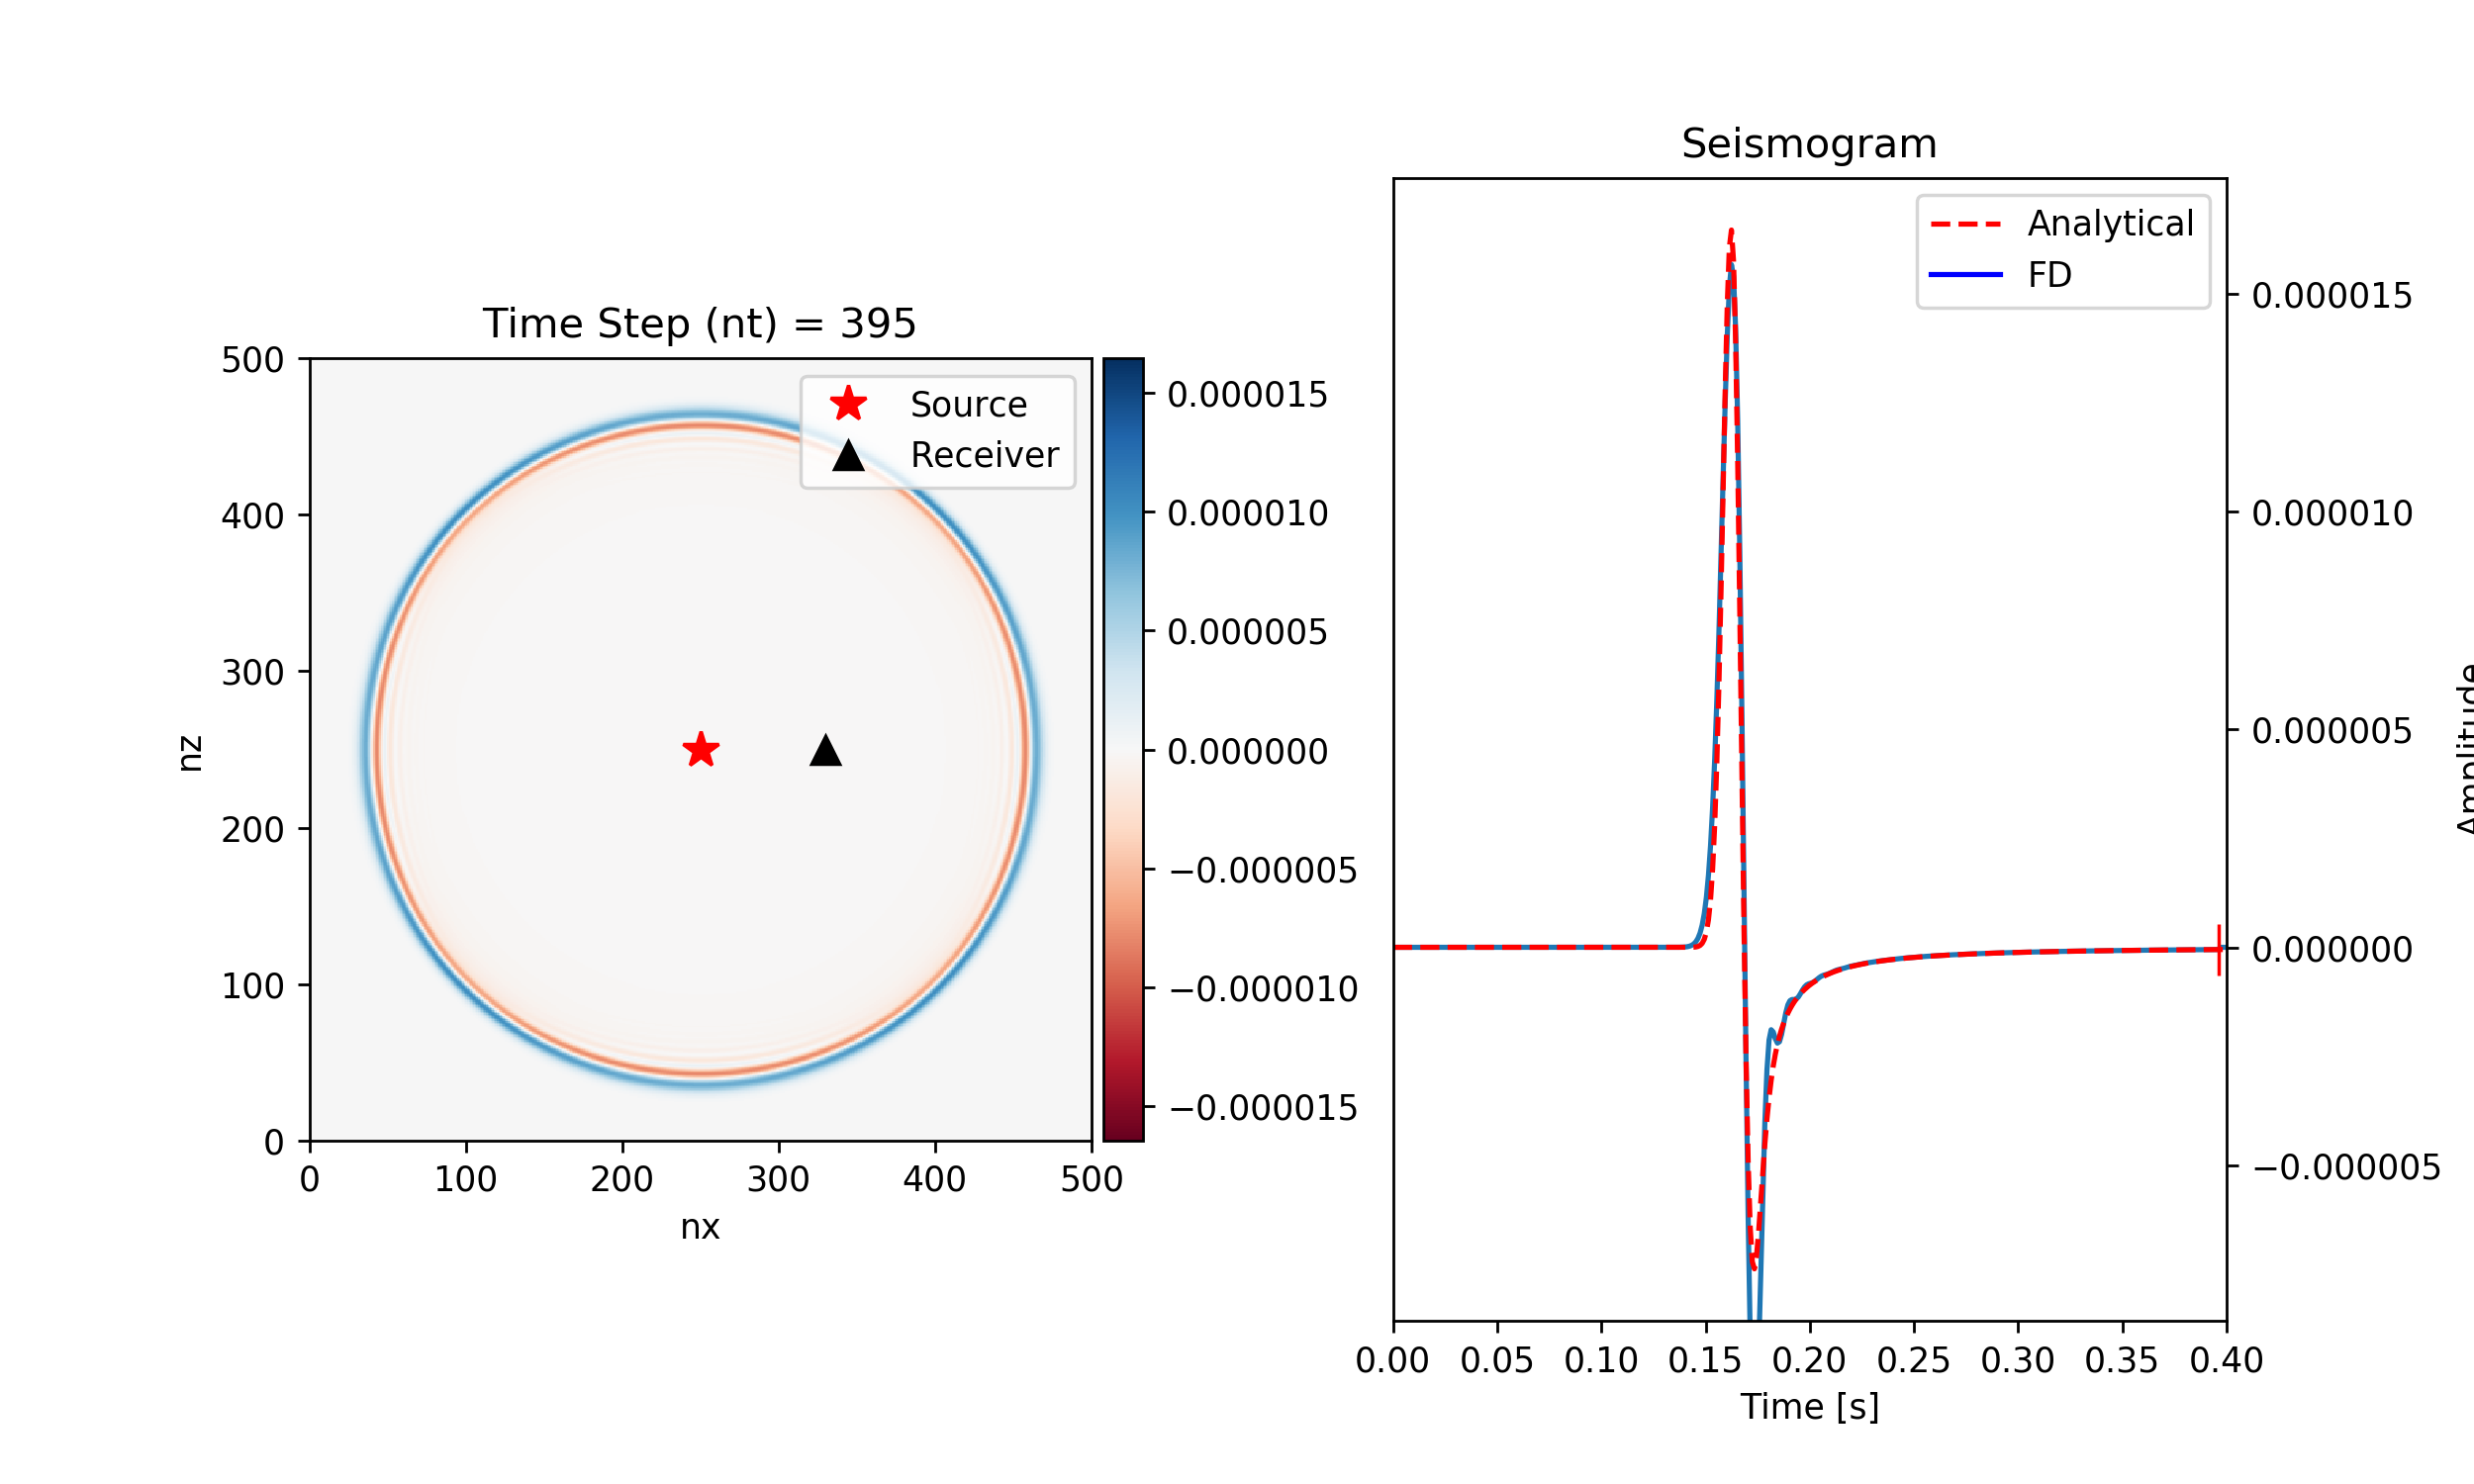

In [5]:
G    = time * 0.
r    = np.sqrt((x[isx] - x[irx]) ** 2 + (z[isz] - z[irz]) ** 2)

for it in range(nt):
    if ((time[it] - np.abs(x[irx] - x[isx]) / c0) >= 0):
        G[it] = (1. / (2 * np.pi * c0 ** 2)) \
        * (1. / np.sqrt((time[it] ** 2) - (r ** 2 / (c0 ** 2))))
Gc   = np.convolve(G, src * dt)
Gc   = Gc[0:nt]
lim  = Gc.max()

plt.ion()
fig2 = plt.figure(figsize=(10, 6))
gs2  = gridspec.GridSpec(1,2,width_ratios=[1,1],hspace=0.3, wspace=0.3)

ax3  = plt.subplot(gs2[0])
leg1,= ax3.plot(isx, isz, 'r*', markersize=11) 
leg2,= ax3.plot(irx, irz, 'k^', markersize=8)  
im3  = ax3.imshow(p, vmin=-lim, vmax=+lim, interpolation="nearest", cmap=plt.cm.RdBu)
div  = make_axes_locatable(ax3)
cax  = div.append_axes("right", size="5%", pad=0.05)
fig2.colorbar(im3, cax=cax)
ax3.set_title('Time Step (nt) = 0')
ax3.set_xlim(0, nx)
ax3.set_ylim(0, nz)
ax3.set_xlabel('nx')
ax3.set_ylabel('nz')
ax3.legend((leg1, leg2), ('Source', 'Receiver'), loc='upper right', fontsize=10, numpoints=1)

ax4  = plt.subplot(gs2[1])
up41,= ax4.plot(time, seis)
up42,= ax4.plot([0], [0], 'r|', markersize=15) 
ax4.set_xlim(time[0], time[-1])
ax4.set_title('Seismogram')
ax4.set_xlabel('Time [s]')
ax4.set_ylabel('Amplitude')
leg3,= ax4.plot(0,0,'r--',markersize=1)
leg4,= ax4.plot(0,0,'b-',markersize=1)
ax4.legend((leg3, leg4), ('Analytical', 'FD'), loc='upper right', fontsize=10, numpoints=1)

ax4.yaxis.tick_right()
ax4.yaxis.set_label_position("right")

plt.plot(time,Gc,'r--')
plt.show()

In [6]:
for it in range(nt):
    if op == 3:
        for i in range(1, nx - 1):
                d2px[i, :] = (p[i - 1, :] - 2 * p[i, :] + p[i + 1, :]) / dx ** 2 
        for j in range(1, nz - 1):
                d2pz[:, j] = (p[:, j - 1] - 2 * p[:, j] + p[:, j + 1]) / dz ** 2 
    
    if op == 5:
        pass
    
    pnew = 2 * p - pold + (c ** 2) * (dt ** 2) * (d2pz + d2px)
    
    pnew[isz, isx] = pnew[isz, isx] + src[it] / (dx * dz) * (dt ** 2) 
    
    pold, p = p, pnew
    
    seis[it] = p[irz, irx]
    
    idisp = 5 
    if (it % idisp) == 0:
        ax3.set_title('Time Step (nt) = %d' % it)
        ax3.imshow(p,vmin=-lim, vmax=+lim, interpolation="nearest", cmap=plt.cm.RdBu)
        up41.set_ydata(seis)
        up42.set_data(time[it], seis[it])
        plt.gcf().canvas.draw()